In [1]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



No GPU available, using the CPU instead.


In [4]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [5]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [6]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


In [7]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [8]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/kaggle/input/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [9]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        

In [10]:
train_dataset = ImgDataset(train_df, root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [11]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.9.crossattention.bias', 'h.10.crossattention.masked_bias', 'h.4.crossattention.q_attn.weight', 'h.8.crossattention.bias', 'h.10.ln_cross_attn.weight', 'h.10.crossattention.bias', 'h.5.crossattention.masked_bias', 'h.9.ln_cross_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.9.crossattention.c_proj.weight', 'h.3.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.8.ln_cross_attn.weight', 'h.10.crossattention.c_proj.weight', 'h.2.crossattention.c_proj.bias', 'h.1.crossattention.q_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.9.crossattention.q_attn.weight', 'h.1.crossattention.c_attn.weight', 'h.8.crossattention.masked_bias', 'h.4.crossattention.c_attn.weight', 'h.3.crossattention.masked_bias', 'h.0.crossattention.c_attn.weight', 'h.11.crossattention.q_attn.weight', 'h.11.crossattention.bias', 'h.11.ln_cross_attn.weight', 'h.6

In [12]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32364
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12138


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,2.616600,2.419088,0.033700,0.256700,0.055900
2,2.134000,2.245660,0.033100,0.298600,0.057900
3,1.806600,2.228173,0.037800,0.301200,0.064000


Saving model checkpoint to VIT_large_gpt2/checkpoint-2048
Configuration saved in VIT_large_gpt2/checkpoint-2048/config.json
Model weights saved in VIT_large_gpt2/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8091
  Batch size = 8
Saving model checkpoint to VIT_large_gpt2/checkpoint-4096
Configuration saved in VIT_large_gpt2/checkpoint-4096/config.json
Model weights saved in VIT_large_gpt2/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_large_gpt2/checkpoint-2048] due to args.save_total_limit
Saving model checkpoint to VIT_large_gpt2/checkpoint-6144
Configuration saved in VIT_large_gpt2/checkpoint-6144/config.json
Model weights saved in VIT_large_gpt2/checkpoint-6144/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-6144/preprocessor_config.json
Delet

TrainOutput(global_step=12138, training_loss=2.272308133386627, metrics={'train_runtime': 24371.0841, 'train_samples_per_second': 3.984, 'train_steps_per_second': 0.498, 'total_flos': 1.7521600116635468e+19, 'train_loss': 2.272308133386627, 'epoch': 3.0})

In [15]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json


In [19]:
epochs = [1, 2, 3]
training_loss = [2.6166, 2.1340, 1.8066]
validation_loss = [2.419088, 2.245660, 2.228173]
rouge2_precision = [0.0337, 0.0331, 0.0378]
rouge2_recall = [0.2567, 0.2986, 0.3012]
rouge2_fmeasure = [0.0559, 0.0579, 0.0640]

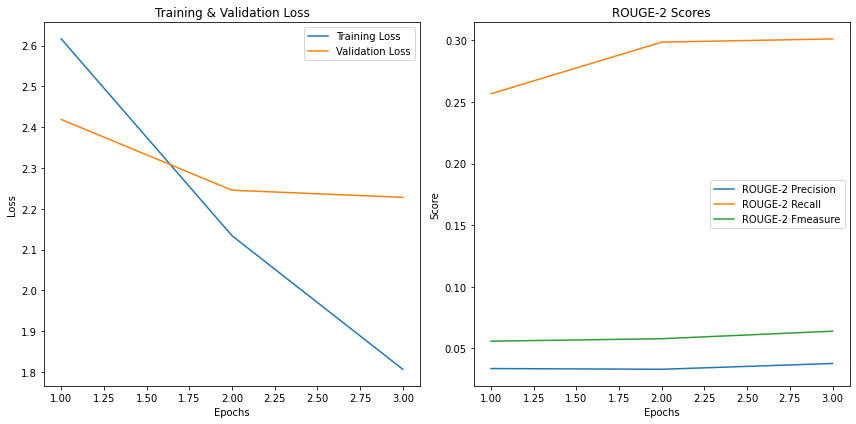

In [20]:
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting ROUGE-2 Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, rouge2_precision, label='ROUGE-2 Precision')
plt.plot(epochs, rouge2_recall, label='ROUGE-2 Recall')
plt.plot(epochs, rouge2_fmeasure, label='ROUGE-2 Fmeasure')
plt.title('ROUGE-2 Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


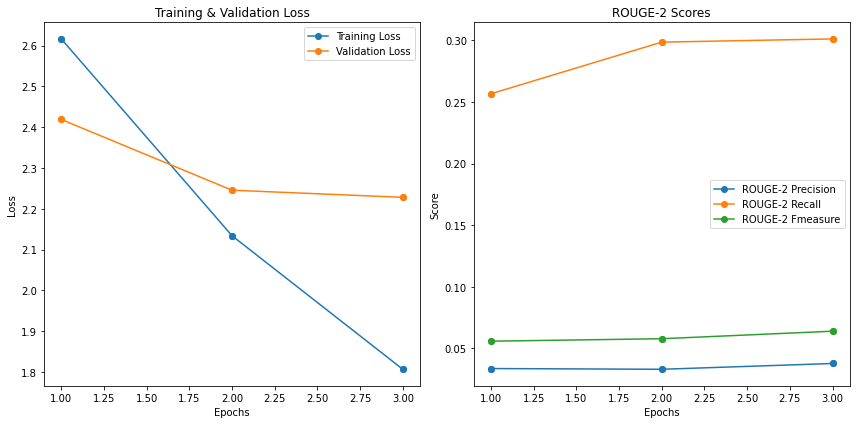

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')  # Added marker
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')  # Added marker
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.scatter(epochs, training_loss)  # Scatter plot for training loss
plt.scatter(epochs, validation_loss)  # Scatter plot for validation loss

# Plotting ROUGE-2 Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, rouge2_precision, label='ROUGE-2 Precision', marker='o')  # Added marker
plt.plot(epochs, rouge2_recall, label='ROUGE-2 Recall', marker='o')  # Added marker
plt.plot(epochs, rouge2_fmeasure, label='ROUGE-2 Fmeasure', marker='o')  # Added marker
plt.title('ROUGE-2 Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.scatter(epochs, rouge2_precision)  # Scatter plot for ROUGE-2 Precision
plt.scatter(epochs, rouge2_recall)  # Scatter plot for ROUGE-2 Recall
plt.scatter(epochs, rouge2_fmeasure)  # Scatter plot for ROUGE-2 Fmeasure

plt.tight_layout()
plt.show()

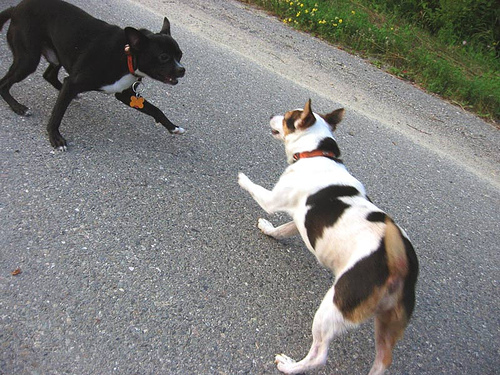

In [22]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\1001773457_577c3a7d70.jpg").convert("RGB")
img

In [23]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

<|endoftext|>A black dog and a white dog are running on the street. Another black dog


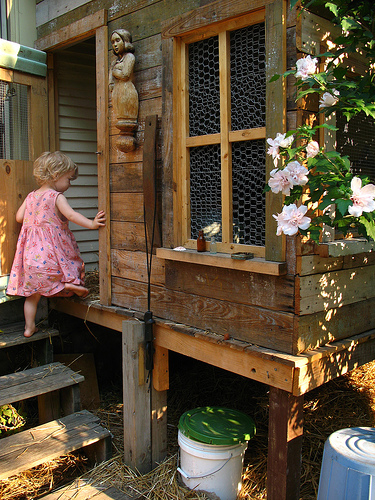

In [24]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\1000268201_693b08cb0e.jpg").convert("RGB")
img

In [25]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A little girl in a pink dress is sitting on a wooden bench in front of a wooden door. Another little girl i


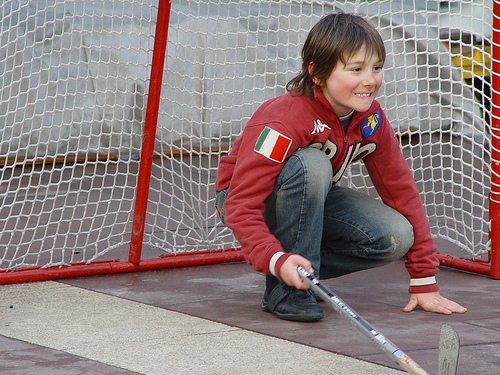

In [26]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\103106960_e8a41d64f8.jpg").convert("RGB")
img 

In [27]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A young girl in a red jacket is holding a hockey stick in front of a red brick wall. Another young girl is 
